In [69]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jun  3 17:36:39 2022

@author: zhuch
"""

# -*- coding: utf-8 -*-
"""
Created on Fri Jun  3 16:30:40 2022

U_net copied from "https://amaarora.github.io/2020/09/13/unet.html"

@author: zhuch
"""
import pickle

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt


In [70]:
#%%

# with open("speckle.dat", 'rb') as f:
#     input_list = pickle.load(f)

# with open("SLM.dat", 'rb') as f:
#     output_list =pickle.load(f)
    
#%%

with open("data/experiment results/Speckle_20x_200um_Round_Scale-2.5x_Natural_M_2_10238_112x112.dat", 'rb') as f:
    input_list = pickle.load(f)

with open("data/experiment results/Natural_10238.dat", 'rb') as f:
    output_list =pickle.load(f)

#%%
# s = input_list[5]
# x = np.arange(0,112,1)
# y = np.arange(0,112,1)
# X,Y = np.meshgrid(x,y)
# plt.figure()
# ax = plt.axes(projection='3d')
# ax.scatter(X,Y,s.reshape(112,112), cmap='viridis')
# # plt.colorbar()
# plt.show()

#%%
N_sample = 10000
train_rate = 0.9
train_set_number = int(train_rate*N_sample)

input_dim = (112,112)

input_H = np.array(input_list).reshape(-1,1, *input_dim)
label = np.array(output_list).reshape(-1,1, 64, 64)

train_number = np.arange(0,N_sample, dtype ='int')
np.random.shuffle(train_number)

x_train = input_H[train_number[0:train_set_number]]
x_test = input_H[train_number[train_set_number:N_sample]]

y_train =label[train_number[0:train_set_number]]
y_test = label[train_number[train_set_number:N_sample]]

x_train = torch.FloatTensor(x_train/256.0)
x_test = torch.FloatTensor(x_test/256.0)

y_train = torch.FloatTensor(y_train/256.0)
y_test = torch.FloatTensor(y_test/256.0)
    
    
batch_size = 200

# create data loaders
train_dataloader = DataLoader(list(zip(x_train, y_train)), batch_size = batch_size )
test_dataloader = DataLoader(list(zip(x_test,y_test)),  batch_size = batch_size )

#%%
del input_list
del output_list
del input_H
del label
#%%
torch.cuda.empty_cache()

In [81]:
#%%
device = "cuda"
import torch.nn.functional as F

# Nnodes = 4096

# class NeuralNetwork(nn.Module):
#     def __init__(self):
#         super(NeuralNetwork, self).__init__()
#         self.fc1 = nn.Linear(112*112, Nnodes)
#         self.fc2 = nn.Linear(Nnodes, 64*64)
#         self.dp = nn.Dropout(0.3)
#         self.BN = nn.BatchNorm1d(Nnodes)
#         self.BN2 = nn.BatchNorm1d(64*64)  
#         self.flatten = nn.Flatten()
        
#     def forward(self, x):
#         x = self.flatten(x)
#         x = self.BN(self.dp(F.relu(self.fc1(x))))
#         x = self.BN2(self.dp(F.sigmoid(self.fc2(x))))
#         # x = self.dp(F.relu(self.fc2(x)))
#         x = x.view(-1,1,64,64)
#         return x

# model = NeuralNetwork().to(device)
# from torchsummary import summary
# summary(model, (1, 112, 112))

#%%
# Define model
Nnodes = 4096

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(112*112, Nnodes)
        self.fc2 = nn.Linear(Nnodes, 64*64)
        self.dp = nn.Dropout(0.2)
        self.BN = nn.BatchNorm1d(Nnodes)
        self.BN2 = nn.BatchNorm1d(64*64)  
        self.BN3 = nn.BatchNorm2d(10)  
        self.ct1 = nn.ConvTranspose2d(1,10,2,stride = 2)
        self.ct2 = nn.ConvTranspose2d(10,6,2,stride = 2)
        
        self.conv2 = nn.Conv2d(6,1,3)
        self.pool = nn.MaxPool2d(2,2)
        self.flatten = nn.Flatten()
        self.fc3 = nn.Linear(3969, 64*64)
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.BN(self.dp(F.leaky_relu(self.fc1(x))))
        x = self.BN2(self.dp(F.sigmoid(self.fc2(x))))
        x = x.view(-1,1,64,64)
        # x = F.relu(self.ct1(x))
        # x = F.relu(self.ct2(x))
        # x = self.pool(self.conv2(x))
        # x = self.flatten(x)
        # x = self.dp(F.leaky_relu(self.fc3(x)))
        # x = x.view(-1,1,64,64)
        return x

pre_model = NeuralNetwork().to(device)
pre_model.load_state_dict(torch.load('model/exp_mlmodel3.dat'))

for param in pre_model.parameters():
    param.requires_grad = False

In [105]:
# with open("data/experiment results/Speckle_20x_200um_Round_Scale-2.5x_Natural_M_2_10238_112x112.dat", 'rb') as f:
#     input_list = pickle.load(f)

# input_H = np.array(input_list).reshape(-1,1, *input_dim)
# x_input = torch.FloatTensor(input_H/256.0)


# pre_model.eval()
# with torch.no_grad():
#     pred = pre_model(x_input.to(device))
#     pred = pred.cpu().detach().numpy()


In [107]:
# with open("data/medium_10238.dat", 'wb') as f:
#     pickle.dump(pred, f)

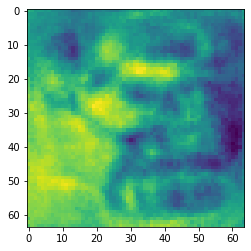

In [111]:
plt.figure()
plt.imshow(pred[1].reshape(64,64))
plt.show()

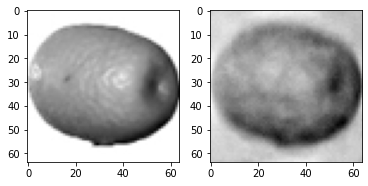

In [103]:
i = np.random.randint(1,1000)
pre_model.eval()
with torch.no_grad():
    pred = pre_model(x_train[i:i+3].to(device))
    pred = pred.cpu().detach().numpy()

plt.figure()
plt.subplot(121)
plt.imshow(y_train[i].reshape(64,64), cmap = 'gray')

plt.subplot(122)
plt.imshow(pred[0].reshape(64,64), cmap = 'gray')
plt.show()

In [61]:
#%%
import torchvision
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
    
    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


class Encoder(nn.Module):
    def __init__(self, chs=(1,64,128)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class UNet(nn.Module):
    def __init__(self, enc_chs=(1,64,128), dec_chs=( 128, 64), num_class=1, retain_dim=True, out_sz=(64,64)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim
        self.out_sz =  out_sz

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, self.out_sz)
        return out

model = UNet().to(device)
#%%

import ssim
loss_fn = ssim.SSIM()

from torch.optim.lr_scheduler import ReduceLROnPlateau
# loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer)


def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred0 = pre_model(X)
        # Compute prediction error
            
        pred = model(pred0)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Train loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss.cpu().detach().numpy()
            
            
def test(dataloader, model, loss_fn):
    # size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred0 = pre_model(X)
            pred = model(pred0)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Test Loss:  {test_loss:>8f} \n")
    return test_loss
    



In [62]:
#%%  Neural network training


epochs = 50

Loss_train = []
Loss_test = []
steps = []

best_loss = 1.0

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss = test(test_dataloader, model, loss_fn)
    Loss_train.append(train_loss)
    Loss_test.append(test_loss)
    if test_loss<best_loss:
        best_loss = test_loss
    steps.append(t)
    scheduler.step(test_loss)
print("Done!")    
    

# %%
# plt.figure(figsize = (8,6))
# plt.title("MSE Loss vs Epochs")
# plt.plot(steps, Loss_train, label = 'train')
# plt.plot(steps, Loss_test, label = 'test')
# plt.xlabel("Epochs")
# plt.ylabel("MSE Loss")
# plt.legend()
# plt.show()


torch.save(model.state_dict(), 'model/SHL_U_net.dat')

#%%
# torch.cuda.empty_cache()

Epoch 1
-------------------------------
Train loss: 0.917918  [    0/ 9000]
Train loss: 0.775942  [ 2000/ 9000]
Train loss: 0.753991  [ 4000/ 9000]
Train loss: 0.747615  [ 6000/ 9000]
Train loss: 0.755989  [ 8000/ 9000]
Test Loss:  0.751356 

Epoch 2
-------------------------------
Train loss: 0.741399  [    0/ 9000]
Train loss: 0.734800  [ 2000/ 9000]
Train loss: 0.737616  [ 4000/ 9000]
Train loss: 0.721842  [ 6000/ 9000]
Train loss: 0.740453  [ 8000/ 9000]
Test Loss:  0.732973 

Epoch 3
-------------------------------
Train loss: 0.722205  [    0/ 9000]
Train loss: 0.727062  [ 2000/ 9000]
Train loss: 0.725952  [ 4000/ 9000]
Train loss: 0.727332  [ 6000/ 9000]
Train loss: 0.735441  [ 8000/ 9000]
Test Loss:  0.725704 

Epoch 4
-------------------------------
Train loss: 0.713706  [    0/ 9000]
Train loss: 0.720965  [ 2000/ 9000]
Train loss: 0.722228  [ 4000/ 9000]
Train loss: 0.711565  [ 6000/ 9000]
Train loss: 0.731863  [ 8000/ 9000]
Test Loss:  0.727477 

Epoch 5
--------------------

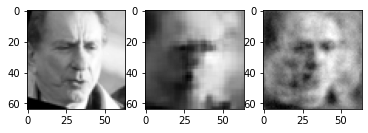

In [68]:
#%%  test model

pre_model_cpu = pre_model.to('cpu')

test_model = UNet().to('cpu')

test_model.load_state_dict(torch.load('model/SHL_U_net.dat'))

test_number = np.random.randint(0,200)

with torch.no_grad():
    test_model.eval()
    X= x_test[test_number].reshape(-1,1,*input_dim)
    pred0 = pre_model_cpu(X)
    pred = test_model(pred0)
plt.figure() 
plt.subplot(131)
plt.imshow(y_test[test_number].reshape(64,64), cmap = 'gray')  
plt.subplot(132)
plt.imshow(pred[0].reshape(64,64), cmap = 'gray')
# plt.imshow(pred[0].reshape(64,64))

plt.subplot(133)
plt.imshow(pred0[0].reshape(64,64), cmap = 'gray')
plt.show()